In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, BatchNormalization, Flatten, Reshape, Concatenate, Bidirectional, LSTM
# from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dj = pd.read_csv("/content/drive/MyDrive/upload_DJIA_table.csv")

In [4]:
dj.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [5]:
dj.shape

(1989, 7)

In [6]:
dj = dj.set_index('Date').diff(periods=1)
dj['Date'] = dj.index
dj = dj.reset_index(drop=True)

In [7]:
dj = dj.drop(['High','Low','Open','Volume','Adj Close'], 1)

In [8]:
 dj = dj.sort_values(by='Date')

In [9]:
from sklearn.preprocessing import MinMaxScaler
input_length = 50
output_length = 1
test_percentage = 0.2
dataset = dj['Close'].to_numpy()

scaler = MinMaxScaler()
dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list = []
for i in range(len(dataset) - input_length - output_length):
    dataset_list.append(dataset_norm[i:i + input_length + output_length])
dataset_list = np.array(dataset_list)
trainset = dataset_list[:int(len(dataset_list) * (1 - test_percentage))]
testset = dataset_list[int(len(dataset_list) * (1 - test_percentage)):]

x_train_price = trainset[:, :-1]
y_train_price = trainset[:, -1:]
x_test_price = testset[:, :-1]
y_test_price = testset[:, -1:]

print('x_train.shape:' + str(x_train_price.shape))
print('y_train.shape:' + str(y_train_price.shape))
print('x_test.shape:' + str(x_test_price.shape))
print('y_test.shape' + str(y_test_price.shape))

x_train.shape:(1550, 50)
y_train.shape:(1550, 1)
x_test.shape:(388, 50)
y_test.shape(388, 1)


In [10]:
df = pd.read_csv("/content/drive/MyDrive/Combined_News_DJIA.csv",  encoding = 'ISO-8859-1')
print(df.count)

<bound method DataFrame.count of             Date  ...                                              Top25
0     2008-08-08  ...           b"No Help for Mexico's Kidnapping Surge"
1     2008-08-11  ...  b"So this is what it's come to: trading sex fo...
2     2008-08-12  ...  b"BBC NEWS | Asia-Pacific | Extinction 'by man...
3     2008-08-13  ...  b'2006: Nobel laureate Aleksander Solzhenitsyn...
4     2008-08-14  ...  b'Philippines : Peace Advocate say Muslims nee...
...          ...  ...                                                ...
1984  2016-06-27  ...  Pakistani clerics declare transgender marriage...
1985  2016-06-28  ...  Mexico's security forces routinely use 'sexual...
1986  2016-06-29  ...  Tiny New Zealand town with 'too many jobs' lau...
1987  2016-06-30  ...  Law Enforcement Sources: Gun Used in Paris Ter...
1988  2016-07-01  ...  Ozone layer hole seems to be healing - US &amp...

[1989 rows x 27 columns]>


In [11]:
train = df[df['Date']<'20150101']
test = df[df['Date'] > '20141231']

print(train.count)
print(test.count)

data = train.iloc[:, 2:27]
data.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

<bound method DataFrame.count of             Date  ...                                              Top25
0     2008-08-08  ...           b"No Help for Mexico's Kidnapping Surge"
1     2008-08-11  ...  b"So this is what it's come to: trading sex fo...
2     2008-08-12  ...  b"BBC NEWS | Asia-Pacific | Extinction 'by man...
3     2008-08-13  ...  b'2006: Nobel laureate Aleksander Solzhenitsyn...
4     2008-08-14  ...  b'Philippines : Peace Advocate say Muslims nee...
...          ...  ...                                                ...
1858  2015-12-24  ...  Cameron, Osborne and Murdoch back together at ...
1859  2015-12-28  ...  Experiment in Germany tests the idea of an 'em...
1860  2015-12-29  ...  Israel warns Brazil to accept its settler amba...
1861  2015-12-30  ...  UK Sperm Bank Doesn't Accept Donors with Dysle...
1862  2015-12-31  ...  Hamas to keep Palestinians from ringing in New...

[1863 rows x 27 columns]>
<bound method DataFrame.count of             Date  ...          

In [12]:
list1 = [i for i in range(25)]
new_Index = [str(i) for i in list1]
data.columns = new_Index
data.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,b Georgia downs two Russian warplanes as cou...,b BREAKING Musharraf to be impeached,b Russia Today Columns of troops roll into So...,b Russian tanks are moving towards the capital...,b Afghan children raped with impunity U N ...,b Russian tanks have entered South Ossetia...,b Breaking Georgia invades South Ossetia Rus...,b The enemy combatent trials are nothing but...,b Georgian troops retreat from S Osettain cap...,b Did the U S Prep Georgia for War with Russia,b Rice Gives Green Light for Israel to Attack ...,b Announcing Class Action Lawsuit on Behalf of...,b So Russia and Georgia are at war and the N...,b China tells Bush to stay out of other countr...,b Did World War III start today,b Georgia Invades South Ossetia if Russia ge...,b Al Qaeda Faces Islamist Backlash,b Condoleezza Rice The US would not act to p...,b This is a busy day The European Union has ...,b Georgia will withdraw soldiers from Ir...,b Why the Pentagon Thinks Attacking Iran is a ...,b Caucasus in crisis Georgia invades South Os...,b Indian shoe manufactory And again in a se...,b Visitors Suffering from Mental Illnesses Ban...,b No Help for Mexico s Kidnapping Surge
1,b Why wont America and Nato help us If they w...,b Bush puts foot down on Georgian conflict,b Jewish Georgian minister Thanks to Israeli ...,b Georgian army flees in disarray as Russians ...,b Olympic opening ceremony fireworks faked,b What were the Mossad with fraudulent New Zea...,b Russia angered by Israeli military sale to G...,b An American citizen living in S Ossetia blam...,b Welcome To World War IV Now In High Definit...,b Georgia s move a mistake of monumental prop...,b Russia presses deeper into Georgia U S say...,b Abhinav Bindra wins first ever Individual Ol...,b U S ship heads for Arctic to define territ...,b Drivers in a Jerusalem taxi station threaten...,b The French Team is Stunned by Phelps and the...,b Israel and the US behind the Georgian aggres...,b Do not believe TV neither Russian nor Geor...,b Riots are still going on in Montreal Canada...,b China to overtake US as largest manufacturer,b War in South Ossetia PICS,b Israeli Physicians Group Condemns State Tort...,b Russia has just beaten the United States ov...,b Perhaps the question about the Georgia R...,b Russia is so much better at war,b So this is what it s come to trading sex fo...
2,b Remember that adorable year old who sang a...,b Russia ends Georgia operation,b If we had no sexual harassment we would hav...,b Al Qa eda is losing support in Iraq because ...,b Ceasefire in Georgia Putin Outmaneuvers the...,b Why Microsoft and Intel tried to kill the XO...,b Stratfor The Russo Georgian War and the Bal...,b I m Trying to Get a Sense of This Whole Geor...,b The US military was surprised by the timing ...,b U S Beats War Drum as Iran Dumps the Dollar,b Gorbachev Georgian military attacked the S...,b CNN use footage of Tskhinvali ruins to cover...,b Beginning a war as the Olympics were opening...,b pyramids as large as the Luxor stacked in...,b The Top Party Cities in the World,b U S troops still in Georgia did you know t...,b Why Russias response to Georgia was right,b Gorbachev accuses U S of making a serious ...,b Russia Georgia and NATO Cold War Two,b Remember that adorable year old who led y...,b War in Georgia The Israeli connection,b All signs point to the US encouraging Georgi...,b Christopher King argues that the US and NATO...,b America The New Mexico,b BBC NEWS Asia Pacific Extinction by man...
3,b U S refuses Israel weapons to attack Iran ...,b When the president ordered to attack Tskhinv...,b Israel clears troops who killed Reuters cam...,b Britain s policy of being tough on drugs is...,b Body of year old found in trunk Latest ...,b China has moved million quake survivors...,b Bush announces Operation Get All Up In Russi...,b Russian forces sink Georgian ships,b The commander of a Navy air reconnaissance s...,b of CNN readers Russia s ac

In [13]:
for index in new_Index:
    data[index] = data[index].str.lower()
data.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,b georgia downs two russian warplanes as cou...,b breaking musharraf to be impeached,b russia today columns of troops roll into so...,b russian tanks are moving towards the capital...,b afghan children raped with impunity u n ...,b russian tanks have entered south ossetia...,b breaking georgia invades south ossetia rus...,b the enemy combatent trials are nothing but...,b georgian troops retreat from s osettain cap...,b did the u s prep georgia for war with russia,b rice gives green light for israel to attack ...,b announcing class action lawsuit on behalf of...,b so russia and georgia are at war and the n...,b china tells bush to stay out of other countr...,b did world war iii start today,b georgia invades south ossetia if russia ge...,b al qaeda faces islamist backlash,b condoleezza rice the us would not act to p...,b this is a busy day the european union has ...,b georgia will withdraw soldiers from ir...,b why the pentagon thinks attacking iran is a ...,b caucasus in crisis georgia invades south os...,b indian shoe manufactory and again in a se...,b visitors suffering from mental illnesses ban...,b no help for mexico s kidnapping surge
1,b why wont america and nato help us if they w...,b bush puts foot down on georgian conflict,b jewish georgian minister thanks to israeli ...,b georgian army flees in disarray as russians ...,b olympic opening ceremony fireworks faked,b what were the mossad with fraudulent new zea...,b russia angered by israeli military sale to g...,b an american citizen living in s ossetia blam...,b welcome to world war iv now in high definit...,b georgia s move a mistake of monumental prop...,b russia presses deeper into georgia u s say...,b abhinav bindra wins first ever individual ol...,b u s ship heads for arctic to define territ...,b drivers in a jerusalem taxi station threaten...,b the french team is stunned by phelps and the...,b israel and the us behind the georgian aggres...,b do not believe tv neither russian nor geor...,b riots are still going on in montreal canada...,b china to overtake us as largest manufacturer,b war in south ossetia pics,b israeli physicians group condemns state tort...,b russia has just beaten the united states ov...,b perhaps the question about the georgia r...,b russia is so much better at war,b so this is what it s come to trading sex fo...


In [14]:
headlines = []
for row in range(0, len(data.index)):
    headlines.append(' '.join(str(x)[1:] for x in data.iloc[row, 0:25]))

In [15]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [16]:
# implememt BAG OF WORDS
tfidfVector = TfidfVectorizer(ngram_range=(2,2))
#ngram(2,2) means it will combine the 2 words together and assign the value

trainDataset = tfidfVector.fit_transform(headlines)

In [17]:
randomClassifier = RandomForestClassifier(n_estimators=200, criterion='entropy')
randomClassifier.fit(trainDataset, train['Label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
testTransform =[]
for row in range(0, len(df.index)):
    testTransform.append(' '.join(str(x)[1:] for x in df.iloc[row, 2:27]))
    
test_dataset = tfidfVector.transform(testTransform)

In [19]:
pred_0 = []
pred_1 = []
predictions = randomClassifier.predict_proba(test_dataset)
print(len(predictions))
for i in predictions:
  pred_0.append(i[0])
  pred_1.append(i[1])

1989


In [20]:
print(len(pred_0))
print(len(pred_1))

1989
1989


In [21]:
from sklearn.preprocessing import MinMaxScaler
input_length = 50
output_length = 1
test_percentage = 0.2
# dataset = dj['Close'].to_numpy()

# scaler = MinMaxScaler()
# dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list_0 = []
dataset_list_1 = []
for i in range(len(pred_0) - input_length - output_length):
    dataset_list_0.append(pred_0[i:i + input_length + output_length])
    dataset_list_1.append(pred_1[i:i + input_length + output_length])
dataset_list_0 = np.array(dataset_list_0)
dataset_list_1 = np.array(dataset_list_1)
trainset_0 = dataset_list_0[:int(len(dataset_list_0) * (1 - test_percentage))]
testset_0 = dataset_list_0[int(len(dataset_list_0) * (1 - test_percentage)):]

trainset_1 = dataset_list_1[:int(len(dataset_list_1) * (1 - test_percentage))]
testset_1 = dataset_list_1[int(len(dataset_list_1) * (1 - test_percentage)):]

x_train_0 = trainset_0[:, :-1]
x_test_0 = testset_0[:, :-1]

x_train_1 = trainset_1[:, :-1]
x_test_1 = testset_1[:, :-1]

print('x_train.shape:' + str(x_train_0.shape))
print('x_test.shape:' + str(x_test_0.shape))

x_train.shape:(1550, 50)
x_test.shape:(388, 50)


In [23]:
input_tensor_c = Input(shape=( x_train_price.shape[1],1), dtype='float32')
x_c = Bidirectional(LSTM(128, return_sequences=True))(input_tensor_c)
x_c = Dropout(0.2)(x_c)
x_c = Bidirectional(LSTM(64, return_sequences=True))(x_c)
x_c = Dropout(0.2)(x_c)
x_c = Bidirectional(LSTM(32, return_sequences=False))(x_c)
x_c = Dropout(0.2)(x_c)

input_tensor_n_0 = Input(shape=( x_train_0.shape[1],1), dtype='float32')
x_n_0 = Bidirectional(LSTM(64, return_sequences=True))(input_tensor_n_0)
x_n_0 = Dropout(0.2)(x_n_0)
x_n_0 = Bidirectional(LSTM(32, return_sequences=False))(x_n_0)
x_n_0 = Dropout(0.2)(x_n_0)


input_tensor_n_1 = Input(shape=( x_train_1.shape[1],1), dtype='float32')
x_n_1 = Bidirectional(LSTM(64, return_sequences=True))(input_tensor_n_1)
x_n_1 = Dropout(0.2)(x_n_1)
x_n_1 = Bidirectional(LSTM(32, return_sequences=False))(x_n_1)
x_n_1 = Dropout(0.2)(x_n_1)

combined = Concatenate()([x_c, x_n_0, x_n_1])

mix2= Dense(256)(combined)
mix2 = Dense(128)(mix2)
mix2 = Dense(64)(mix2)
mix2 = Dense(32)(mix2)
mix2 = Dense(16)(mix2)
mix2 = Dense(8)(mix2)
mix2 = Dense(4)(mix2)

out1 = Dense(1)(mix2)


regressor = Model(inputs=[input_tensor_c,input_tensor_n_0,input_tensor_n_1],outputs=[out1])

In [24]:
regressor.compile(optimizer = "rmsprop", loss = 'mean_squared_error')
regressor.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 256)      133120      input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 50, 256)      0           bidirectional[0][0]              
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 50, 1)]      0                                            
______________________________________________________________________________________________

In [25]:
regressor.fit([x_train_price, x_train_0, x_train_1], [y_train_price], epochs = 100, batch_size = 8)
# regressor.save("/content/drive/MyDrive/news-stock-no-headlines.h5")

Epoch 1/100
194/194 [==============================] - 58s 52ms/step - loss: 0.1685
Epoch 2/100
194/194 [==============================] - 10s 52ms/step - loss: 0.0091
Epoch 3/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0075
Epoch 4/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0076
Epoch 5/100
194/194 [==============================] - 10s 50ms/step - loss: 0.0080
Epoch 6/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0071
Epoch 7/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0068
Epoch 8/100
194/194 [==============================] - 10s 52ms/step - loss: 0.0068
Epoch 9/100
194/194 [==============================] - 10s 52ms/step - loss: 0.0050
Epoch 10/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0055
Epoch 11/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0048
Epoch 12/100
194/194 [==============================] - 10s 51ms/step - lo

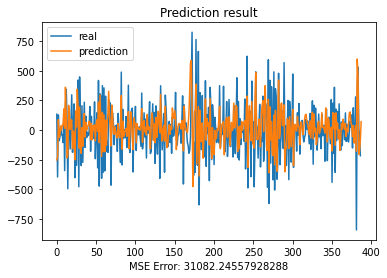

In [34]:
from sklearn.metrics.regression import mean_squared_error
y_predict = regressor.predict([x_test_price, x_test_0, x_test_1])
y_real = scaler.inverse_transform(y_test_price.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()

# print(y_real)
# print(y_predict)

# print(np.any(np.isnan(y_predict)))
# difference_array = np.subtract(y_real, y_predict)
# print(difference_array)
# squared_array = np.square(difference_array)
# mse = squared_array.mean()
# print(mse)
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real[:-1], y_predict[:-1])))
plt.legend()
plt.title('Prediction result')
plt.show()

In [35]:
regressor.save("/content/drive/MyDrive/news-stock-rate-25-headlines.h5")

In [106]:
from keras.models import load_model
regressor = load_model("/content/drive/MyDrive/news-stock-rate-25-headlines.h5")


from sklearn.preprocessing import MinMaxScaler
input_length = 50
output_length = 1
test_percentage = 0.2
# dataset = dj['Close'].to_numpy()

# scaler = MinMaxScaler()
# dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list_0 = []
dataset_list_1 = []
for i in range(len(pred_0) - input_length - output_length):
    dataset_list_0.append(pred_0[i:i + input_length + output_length])
    dataset_list_1.append(pred_1[i:i + input_length + output_length])
dataset_list_0 = np.array(dataset_list_0)
dataset_list_1 = np.array(dataset_list_1)
trainset_0 = dataset_list_0[:int(len(dataset_list_0) * (1 - test_percentage))]
testset_0 = dataset_list_0[int(len(dataset_list_0) * (1 - test_percentage)):]

trainset_1 = dataset_list_1[:int(len(dataset_list_1) * (1 - test_percentage))]
testset_1 = dataset_list_1[int(len(dataset_list_1) * (1 - test_percentage)):]

x_train_0 = trainset_0[:, :-1]
y_train_0 = trainset_0[:, -1:]
x_test_0 = testset_0[:, :-1]
y_test_0 = testset_0[:, -1:]

x_train_1 = trainset_1[:, :-1]
y_train_1 = trainset_1[:, -1:]
x_test_1 = testset_1[:, :-1]
y_test_1 = testset_1[:, -1:]

y_predict = regressor.predict([x_train_price, x_train_0, x_train_1])
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()


p_50 = []
p_60 = []
p_70 = []
p_80 = []
p_90 = []

n_50 = []
n_60 = []
n_70 = []
n_80 = []
n_90 = []

for i in range(0, len(y_predict)):
  if y_train_0[i] > 0.50 and y_train_0[i] < 0.60:
    n_50.append(y_predict[i])
  if y_train_0[i] >= 0.60 and y_train_0[i] < 0.70:
    n_60.append(y_predict[i])
  if y_train_0[i] >= 0.70 and y_train_0[i] < 0.80:
    n_70.append(y_predict[i])
  if y_train_0[i] >= 0.80 and y_train_0[i] < 0.90:
    n_80.append(y_predict[i])
  if y_train_0[i] >= 0.90 and y_train_0[i] < 1.00:
    n_90.append(y_predict[i])

  if y_train_1[i] > 0.50 and y_train_1[i] < 0.60:
    p_50.append(y_predict[i])
  if y_train_1[i] >= 0.60 and y_train_1[i] < 0.70:
    p_60.append(y_predict[i])
  if y_train_1[i] >= 0.70 and y_train_1[i] < 0.80:
    p_70.append(y_predict[i])
  if y_train_1[i] >= 0.80 and y_train_1[i] < 0.90:
    p_80.append(y_predict[i])
  if y_train_1[i] >= 0.90 and y_train_1[i] < 1.00:
    p_90.append(y_predict[i])

import statistics
print(statistics.mean(n_50))
print(statistics.mean(n_60))
print(statistics.mean(n_70))
print(statistics.mean(n_80))
# print(statistics.mean(n_90))

# print(statistics.mean(p_50))
print(statistics.mean(p_60))
print(statistics.mean(p_70))
print(statistics.mean(p_80))
print(statistics.mean(p_90))

-181.59612
2.5958893
8.933651
4.4273834
-68.68388
36.077305
23.520283
-17.736248


In [ ]:
from keras.models import load_model
regressor = load_model("/content/drive/MyDrive/news-stock-rate-25-headlines.h5")
y_predict = regressor.predict([x_test_price, x_test_0, x_test_1])
y_real = scaler.inverse_transform(y_test_price.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()

In [ ]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_real, y_predict))
from sklearn.metrics import r2_score
print(r2_score(y_real, y_predict))

320.4131816050257
0.6244357284049404


In [22]:

headlines = []
for row in range(0, len(data.index)):
    headlines.append(' '.join(str(x) for x in data.iloc[row, 0:20]))

In [23]:
# implememt BAG OF WORDS
tfidfVector = TfidfVectorizer(ngram_range=(2,2))
#ngram(2,2) means it will combine the 2 words together and assign the value

trainDataset = tfidfVector.fit_transform(headlines)

In [24]:
randomClassifier = RandomForestClassifier(n_estimators=200, criterion='entropy')
randomClassifier.fit(trainDataset, train['Label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
testTransform =[]
for row in range(0, len(df.index)):
    testTransform.append(' '.join(str(x)[1:] for x in df.iloc[row, 2:22]))
    
test_dataset = tfidfVector.transform(testTransform)

In [26]:
pred_0 = []
pred_1 = []
predictions = randomClassifier.predict_proba(test_dataset)
print(len(predictions))
for i in predictions:
  pred_0.append(i[0])
  pred_1.append(i[1])

1989


In [27]:
print(len(pred_0))
print(len(pred_1))

1989
1989


In [28]:
from sklearn.preprocessing import MinMaxScaler
input_length = 50
output_length = 1
test_percentage = 0.2
# dataset = dj['Close'].to_numpy()

# scaler = MinMaxScaler()
# dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list_0 = []
dataset_list_1 = []
for i in range(len(pred_0) - input_length - output_length):
    dataset_list_0.append(pred_0[i:i + input_length + output_length])
    dataset_list_1.append(pred_1[i:i + input_length + output_length])
dataset_list_0 = np.array(dataset_list_0)
dataset_list_1 = np.array(dataset_list_1)
trainset_0 = dataset_list_0[:int(len(dataset_list_0) * (1 - test_percentage))]
testset_0 = dataset_list_0[int(len(dataset_list_0) * (1 - test_percentage)):]

trainset_1 = dataset_list_1[:int(len(dataset_list_1) * (1 - test_percentage))]
testset_1 = dataset_list_1[int(len(dataset_list_1) * (1 - test_percentage)):]

x_train_0 = trainset_0[:, :-1]
x_test_0 = testset_0[:, :-1]

x_train_1 = trainset_1[:, :-1]
x_test_1 = testset_1[:, :-1]

print('x_train.shape:' + str(x_train_0.shape))
print('x_test.shape:' + str(x_test_0.shape))

x_train.shape:(1550, 50)
x_test.shape:(388, 50)


In [43]:
input_tensor_c = Input(shape=( x_train_price.shape[1],1), dtype='float32')
x_c = Bidirectional(LSTM(128, return_sequences=True))(input_tensor_c)
x_c = Dropout(0.2)(x_c)
x_c = Bidirectional(LSTM(64, return_sequences=True))(x_c)
x_c = Dropout(0.2)(x_c)
x_c = Bidirectional(LSTM(32, return_sequences=False))(x_c)
x_c = Dropout(0.2)(x_c)

input_tensor_n_0 = Input(shape=( x_train_0.shape[1],1), dtype='float32')
x_n_0 = Bidirectional(LSTM(64, return_sequences=True))(input_tensor_n_0)
x_n_0 = Dropout(0.2)(x_n_0)
x_n_0 = Bidirectional(LSTM(32, return_sequences=False))(x_n_0)
x_n_0 = Dropout(0.2)(x_n_0)


input_tensor_n_1 = Input(shape=( x_train_1.shape[1],1), dtype='float32')
x_n_1 = Bidirectional(LSTM(64, return_sequences=True))(input_tensor_n_1)
x_n_1 = Dropout(0.2)(x_n_1)
x_n_1 = Bidirectional(LSTM(32, return_sequences=False))(x_n_1)
x_n_1 = Dropout(0.2)(x_n_1)

combined = Concatenate()([x_c, x_n_0, x_n_1])

mix2= Dense(256)(combined)
mix2 = Dense(128)(mix2)
mix2 = Dense(64)(mix2)
mix2 = Dense(32)(mix2)
mix2 = Dense(16)(mix2)
mix2 = Dense(8)(mix2)
mix2 = Dense(4)(mix2)

out1 = Dense(1)(mix2)


regressor = Model(inputs=[input_tensor_c,input_tensor_n_0,input_tensor_n_1],outputs=[out1])

In [44]:
regressor.compile(optimizer = "rmsprop", loss = 'mean_squared_error')
regressor.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 50, 256)      133120      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 50, 256)      0           bidirectional_7[0][0]            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 50, 1)]      0                                            
____________________________________________________________________________________________

In [45]:
regressor.fit([x_train_price, x_train_0, x_train_1], [y_train_price], epochs = 100, batch_size = 8)
# regressor.save("/content/drive/MyDrive/news-stock-no-headlines.h5")

Epoch 1/100
194/194 [==============================] - 27s 52ms/step - loss: 0.1854
Epoch 2/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0087
Epoch 3/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0070
Epoch 4/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0073
Epoch 5/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0070
Epoch 6/100
194/194 [==============================] - 10s 50ms/step - loss: 0.0076
Epoch 7/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0069
Epoch 8/100
194/194 [==============================] - 10s 50ms/step - loss: 0.0054
Epoch 9/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0051
Epoch 10/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0044
Epoch 11/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0049
Epoch 12/100
194/194 [==============================] - 10s 51ms/step - lo

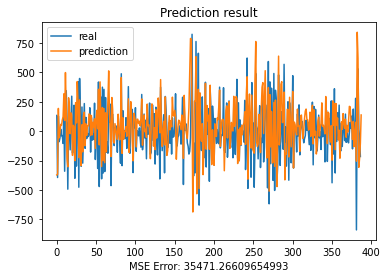

In [46]:
from sklearn.metrics.regression import mean_squared_error
y_predict = regressor.predict([x_test_price, x_test_0, x_test_1])
y_real = scaler.inverse_transform(y_test_price.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real[:-1], y_predict[:-1])))
plt.legend()
plt.title('Prediction result')
plt.show()

In [47]:
regressor.save("/content/drive/MyDrive/news-stock-rate-20-headlines.h5")

In [29]:
from keras.models import load_model
regressor = load_model("/content/drive/MyDrive/news-stock-rate-20-headlines.h5")
y_predict = regressor.predict([x_test_price, x_test_0, x_test_1])
y_real = scaler.inverse_transform(y_test_price.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()

In [31]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_real[:-1], y_predict[:-1]))
from sklearn.metrics import r2_score
print(r2_score(y_real, y_predict))

452.8445008152215
-7.798560544182278


In [32]:

headlines = []
for row in range(0, len(data.index)):
    headlines.append(' '.join(str(x) for x in data.iloc[row, 0:15]))

In [33]:
# implememt BAG OF WORDS
tfidfVector = TfidfVectorizer(ngram_range=(2,2))
#ngram(2,2) means it will combine the 2 words together and assign the value

trainDataset = tfidfVector.fit_transform(headlines)

In [34]:
randomClassifier = RandomForestClassifier(n_estimators=200, criterion='entropy')
randomClassifier.fit(trainDataset, train['Label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
testTransform =[]
for row in range(0, len(df.index)):
    testTransform.append(' '.join(str(x)[1:] for x in df.iloc[row, 2:17]))
    
test_dataset = tfidfVector.transform(testTransform)

In [36]:
pred_0 = []
pred_1 = []
predictions = randomClassifier.predict_proba(test_dataset)
print(len(predictions))
for i in predictions:
  pred_0.append(i[0])
  pred_1.append(i[1])

1989


In [37]:
print(len(pred_0))
print(len(pred_1))

1989
1989


In [38]:
from sklearn.preprocessing import MinMaxScaler
input_length = 50
output_length = 1
test_percentage = 0.2
# dataset = dj['Close'].to_numpy()

# scaler = MinMaxScaler()
# dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list_0 = []
dataset_list_1 = []
for i in range(len(pred_0) - input_length - output_length):
    dataset_list_0.append(pred_0[i:i + input_length + output_length])
    dataset_list_1.append(pred_1[i:i + input_length + output_length])
dataset_list_0 = np.array(dataset_list_0)
dataset_list_1 = np.array(dataset_list_1)
trainset_0 = dataset_list_0[:int(len(dataset_list_0) * (1 - test_percentage))]
testset_0 = dataset_list_0[int(len(dataset_list_0) * (1 - test_percentage)):]

trainset_1 = dataset_list_1[:int(len(dataset_list_1) * (1 - test_percentage))]
testset_1 = dataset_list_1[int(len(dataset_list_1) * (1 - test_percentage)):]

x_train_0 = trainset_0[:, :-1]
x_test_0 = testset_0[:, :-1]

x_train_1 = trainset_1[:, :-1]
x_test_1 = testset_1[:, :-1]

print('x_train.shape:' + str(x_train_0.shape))
print('x_test.shape:' + str(x_test_0.shape))

x_train.shape:(1550, 50)
x_test.shape:(388, 50)


In [55]:
input_tensor_c = Input(shape=( x_train_price.shape[1],1), dtype='float32')
x_c = Bidirectional(LSTM(128, return_sequences=True))(input_tensor_c)
x_c = Dropout(0.2)(x_c)
x_c = Bidirectional(LSTM(64, return_sequences=True))(x_c)
x_c = Dropout(0.2)(x_c)
x_c = Bidirectional(LSTM(32, return_sequences=False))(x_c)
x_c = Dropout(0.2)(x_c)

input_tensor_n_0 = Input(shape=( x_train_0.shape[1],1), dtype='float32')
x_n_0 = Bidirectional(LSTM(64, return_sequences=True))(input_tensor_n_0)
x_n_0 = Dropout(0.2)(x_n_0)
x_n_0 = Bidirectional(LSTM(32, return_sequences=False))(x_n_0)
x_n_0 = Dropout(0.2)(x_n_0)


input_tensor_n_1 = Input(shape=( x_train_1.shape[1],1), dtype='float32')
x_n_1 = Bidirectional(LSTM(64, return_sequences=True))(input_tensor_n_1)
x_n_1 = Dropout(0.2)(x_n_1)
x_n_1 = Bidirectional(LSTM(32, return_sequences=False))(x_n_1)
x_n_1 = Dropout(0.2)(x_n_1)

combined = Concatenate()([x_c, x_n_0, x_n_1])

mix2= Dense(256)(combined)
mix2 = Dense(128)(mix2)
mix2 = Dense(64)(mix2)
mix2 = Dense(32)(mix2)
mix2 = Dense(16)(mix2)
mix2 = Dense(8)(mix2)
mix2 = Dense(4)(mix2)

out1 = Dense(1)(mix2)


regressor = Model(inputs=[input_tensor_c,input_tensor_n_0,input_tensor_n_1],outputs=[out1])

In [56]:
regressor.compile(optimizer = "rmsprop", loss = 'mean_squared_error')
regressor.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional_14 (Bidirectional (None, 50, 256)      133120      input_7[0][0]                    
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 50, 256)      0           bidirectional_14[0][0]           
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 50, 1)]      0                                            
____________________________________________________________________________________________

In [57]:
regressor.fit([x_train_price, x_train_0, x_train_1], [y_train_price], epochs = 100, batch_size = 8)
# regressor.save("/content/drive/MyDrive/news-stock-no-headlines.h5")

Epoch 1/100
194/194 [==============================] - 26s 50ms/step - loss: 0.2255
Epoch 2/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0085
Epoch 3/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0070
Epoch 4/100
194/194 [==============================] - 10s 50ms/step - loss: 0.0073
Epoch 5/100
194/194 [==============================] - 10s 50ms/step - loss: 0.0067
Epoch 6/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0064
Epoch 7/100
194/194 [==============================] - 10s 50ms/step - loss: 0.0067
Epoch 8/100
194/194 [==============================] - 10s 49ms/step - loss: 0.0067
Epoch 9/100
194/194 [==============================] - 9s 49ms/step - loss: 0.0071
Epoch 10/100
194/194 [==============================] - 10s 49ms/step - loss: 0.0066
Epoch 11/100
194/194 [==============================] - 10s 49ms/step - loss: 0.0056
Epoch 12/100
194/194 [==============================] - 9s 49ms/step - loss

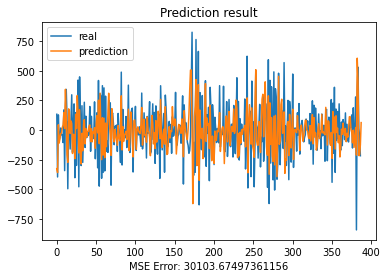

In [59]:
from sklearn.metrics.regression import mean_squared_error
y_predict = regressor.predict([x_test_price, x_test_0, x_test_1])
y_real = scaler.inverse_transform(y_test_price.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real[:-1], y_predict[:-1])))
plt.legend()
plt.title('Prediction result')
plt.show()

In [60]:
regressor.save("/content/drive/MyDrive/news-stock-rate-15-headlines.h5")

In [39]:
from keras.models import load_model
regressor = load_model("/content/drive/MyDrive/news-stock-rate-15-headlines.h5")
y_predict = regressor.predict([x_test_price, x_test_0, x_test_1])
y_real = scaler.inverse_transform(y_test_price.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()

In [40]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_real[:-1], y_predict[:-1]))
from sklearn.metrics import r2_score
print(r2_score(y_real, y_predict))

389.8143195800554
-5.6763212435371395


In [41]:

headlines = []
for row in range(0, len(data.index)):
    headlines.append(' '.join(str(x) for x in data.iloc[row, 0:10]))

In [42]:
# implememt BAG OF WORDS
tfidfVector = TfidfVectorizer(ngram_range=(2,2))
#ngram(2,2) means it will combine the 2 words together and assign the value

trainDataset = tfidfVector.fit_transform(headlines)

In [43]:
randomClassifier = RandomForestClassifier(n_estimators=200, criterion='entropy')
randomClassifier.fit(trainDataset, train['Label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:
testTransform =[]
for row in range(0, len(df.index)):
    testTransform.append(' '.join(str(x)[1:] for x in df.iloc[row, 2:12]))
    
test_dataset = tfidfVector.transform(testTransform)

In [45]:
pred_0 = []
pred_1 = []
predictions = randomClassifier.predict_proba(test_dataset)
print(len(predictions))
for i in predictions:
  pred_0.append(i[0])
  pred_1.append(i[1])

1989


In [46]:
print(len(pred_0))
print(len(pred_1))

1989
1989


In [47]:
from sklearn.preprocessing import MinMaxScaler
input_length = 50
output_length = 1
test_percentage = 0.2
# dataset = dj['Close'].to_numpy()

# scaler = MinMaxScaler()
# dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list_0 = []
dataset_list_1 = []
for i in range(len(pred_0) - input_length - output_length):
    dataset_list_0.append(pred_0[i:i + input_length + output_length])
    dataset_list_1.append(pred_1[i:i + input_length + output_length])
dataset_list_0 = np.array(dataset_list_0)
dataset_list_1 = np.array(dataset_list_1)
trainset_0 = dataset_list_0[:int(len(dataset_list_0) * (1 - test_percentage))]
testset_0 = dataset_list_0[int(len(dataset_list_0) * (1 - test_percentage)):]

trainset_1 = dataset_list_1[:int(len(dataset_list_1) * (1 - test_percentage))]
testset_1 = dataset_list_1[int(len(dataset_list_1) * (1 - test_percentage)):]

x_train_0 = trainset_0[:, :-1]
x_test_0 = testset_0[:, :-1]

x_train_1 = trainset_1[:, :-1]
x_test_1 = testset_1[:, :-1]

print('x_train.shape:' + str(x_train_0.shape))
print('x_test.shape:' + str(x_test_0.shape))

x_train.shape:(1550, 50)
x_test.shape:(388, 50)


In [68]:
input_tensor_c = Input(shape=( x_train_price.shape[1],1), dtype='float32')
x_c = Bidirectional(LSTM(128, return_sequences=True))(input_tensor_c)
x_c = Dropout(0.2)(x_c)
x_c = Bidirectional(LSTM(64, return_sequences=True))(x_c)
x_c = Dropout(0.2)(x_c)
x_c = Bidirectional(LSTM(32, return_sequences=False))(x_c)
x_c = Dropout(0.2)(x_c)

input_tensor_n_0 = Input(shape=( x_train_0.shape[1],1), dtype='float32')
x_n_0 = Bidirectional(LSTM(64, return_sequences=True))(input_tensor_n_0)
x_n_0 = Dropout(0.2)(x_n_0)
x_n_0 = Bidirectional(LSTM(32, return_sequences=False))(x_n_0)
x_n_0 = Dropout(0.2)(x_n_0)


input_tensor_n_1 = Input(shape=( x_train_1.shape[1],1), dtype='float32')
x_n_1 = Bidirectional(LSTM(64, return_sequences=True))(input_tensor_n_1)
x_n_1 = Dropout(0.2)(x_n_1)
x_n_1 = Bidirectional(LSTM(32, return_sequences=False))(x_n_1)
x_n_1 = Dropout(0.2)(x_n_1)

combined = Concatenate()([x_c, x_n_0, x_n_1])

mix2= Dense(256)(combined)
mix2 = Dense(128)(mix2)
mix2 = Dense(64)(mix2)
mix2 = Dense(32)(mix2)
mix2 = Dense(16)(mix2)
mix2 = Dense(8)(mix2)
mix2 = Dense(4)(mix2)

out1 = Dense(1)(mix2)


regressor = Model(inputs=[input_tensor_c,input_tensor_n_0,input_tensor_n_1],outputs=[out1])

In [69]:
regressor.compile(optimizer = "rmsprop", loss = 'mean_squared_error')
regressor.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional_21 (Bidirectional (None, 50, 256)      133120      input_10[0][0]                   
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 50, 256)      0           bidirectional_21[0][0]           
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 50, 1)]      0                                            
____________________________________________________________________________________________

In [70]:
regressor.fit([x_train_price, x_train_0, x_train_1], [y_train_price], epochs = 100, batch_size = 8)
# regressor.save("/content/drive/MyDrive/news-stock-no-headlines.h5")

Epoch 1/100
194/194 [==============================] - 26s 51ms/step - loss: 0.4502
Epoch 2/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0089
Epoch 3/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0090
Epoch 4/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0081
Epoch 5/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0071
Epoch 6/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0075
Epoch 7/100
194/194 [==============================] - 10s 50ms/step - loss: 0.0081
Epoch 8/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0068
Epoch 9/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0066
Epoch 10/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0064
Epoch 11/100
194/194 [==============================] - 10s 52ms/step - loss: 0.0075
Epoch 12/100
194/194 [==============================] - 10s 51ms/step - lo

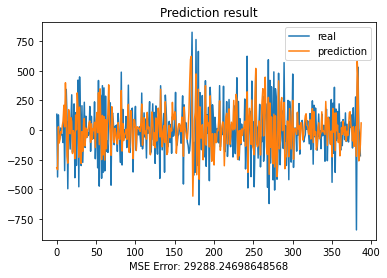

In [71]:
from sklearn.metrics.regression import mean_squared_error
y_predict = regressor.predict([x_test_price, x_test_0, x_test_1])
y_real = scaler.inverse_transform(y_test_price.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real[:-1], y_predict[:-1])))
plt.legend()
plt.title('Prediction result')
plt.show()

In [72]:
regressor.save("/content/drive/MyDrive/news-stock-rate-10-headlines.h5")

In [48]:
from keras.models import load_model
regressor = load_model("/content/drive/MyDrive/news-stock-rate-10-headlines.h5")
y_predict = regressor.predict([x_test_price, x_test_0, x_test_1])
y_real = scaler.inverse_transform(y_test_price.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()

In [49]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_real[:-1], y_predict[:-1]))
from sklearn.metrics import r2_score
print(r2_score(y_real, y_predict))

476.64029182908894
-8.251985588472019


In [50]:

headlines = []
for row in range(0, len(data.index)):
    headlines.append(' '.join(str(x) for x in data.iloc[row, 0:5]))

In [51]:
# implememt BAG OF WORDS
tfidfVector = TfidfVectorizer(ngram_range=(2,2))
#ngram(2,2) means it will combine the 2 words together and assign the value

trainDataset = tfidfVector.fit_transform(headlines)

In [52]:
randomClassifier = RandomForestClassifier(n_estimators=200, criterion='entropy')
randomClassifier.fit(trainDataset, train['Label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
testTransform =[]
for row in range(0, len(df.index)):
    testTransform.append(' '.join(str(x)[1:] for x in df.iloc[row, 2:7]))
    
test_dataset = tfidfVector.transform(testTransform)

In [54]:
pred_0 = []
pred_1 = []
predictions = randomClassifier.predict_proba(test_dataset)
print(len(predictions))
for i in predictions:
  pred_0.append(i[0])
  pred_1.append(i[1])

1989


In [55]:
print(len(pred_0))
print(len(pred_1))

1989
1989


In [56]:
from sklearn.preprocessing import MinMaxScaler
input_length = 50
output_length = 1
test_percentage = 0.2
# dataset = dj['Close'].to_numpy()

# scaler = MinMaxScaler()
# dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list_0 = []
dataset_list_1 = []
for i in range(len(pred_0) - input_length - output_length):
    dataset_list_0.append(pred_0[i:i + input_length + output_length])
    dataset_list_1.append(pred_1[i:i + input_length + output_length])
dataset_list_0 = np.array(dataset_list_0)
dataset_list_1 = np.array(dataset_list_1)
trainset_0 = dataset_list_0[:int(len(dataset_list_0) * (1 - test_percentage))]
testset_0 = dataset_list_0[int(len(dataset_list_0) * (1 - test_percentage)):]

trainset_1 = dataset_list_1[:int(len(dataset_list_1) * (1 - test_percentage))]
testset_1 = dataset_list_1[int(len(dataset_list_1) * (1 - test_percentage)):]

x_train_0 = trainset_0[:, :-1]
x_test_0 = testset_0[:, :-1]

x_train_1 = trainset_1[:, :-1]
x_test_1 = testset_1[:, :-1]

print('x_train.shape:' + str(x_train_0.shape))
print('x_test.shape:' + str(x_test_0.shape))

x_train.shape:(1550, 50)
x_test.shape:(388, 50)


In [80]:
input_tensor_c = Input(shape=( x_train_price.shape[1],1), dtype='float32')
x_c = Bidirectional(LSTM(128, return_sequences=True))(input_tensor_c)
x_c = Dropout(0.2)(x_c)
x_c = Bidirectional(LSTM(64, return_sequences=True))(x_c)
x_c = Dropout(0.2)(x_c)
x_c = Bidirectional(LSTM(32, return_sequences=False))(x_c)
x_c = Dropout(0.2)(x_c)

input_tensor_n_0 = Input(shape=( x_train_0.shape[1],1), dtype='float32')
x_n_0 = Bidirectional(LSTM(64, return_sequences=True))(input_tensor_n_0)
x_n_0 = Dropout(0.2)(x_n_0)
x_n_0 = Bidirectional(LSTM(32, return_sequences=False))(x_n_0)
x_n_0 = Dropout(0.2)(x_n_0)


input_tensor_n_1 = Input(shape=( x_train_1.shape[1],1), dtype='float32')
x_n_1 = Bidirectional(LSTM(64, return_sequences=True))(input_tensor_n_1)
x_n_1 = Dropout(0.2)(x_n_1)
x_n_1 = Bidirectional(LSTM(32, return_sequences=False))(x_n_1)
x_n_1 = Dropout(0.2)(x_n_1)

combined = Concatenate()([x_c, x_n_0, x_n_1])

mix2= Dense(256)(combined)
mix2 = Dense(128)(mix2)
mix2 = Dense(64)(mix2)
mix2 = Dense(32)(mix2)
mix2 = Dense(16)(mix2)
mix2 = Dense(8)(mix2)
mix2 = Dense(4)(mix2)

out1 = Dense(1)(mix2)


regressor = Model(inputs=[input_tensor_c,input_tensor_n_0,input_tensor_n_1],outputs=[out1])

In [81]:
regressor.compile(optimizer = "rmsprop", loss = 'mean_squared_error')
regressor.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional_28 (Bidirectional (None, 50, 256)      133120      input_13[0][0]                   
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 50, 256)      0           bidirectional_28[0][0]           
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 50, 1)]      0                                            
____________________________________________________________________________________________

In [82]:
regressor.fit([x_train_price, x_train_0, x_train_1], [y_train_price], epochs = 100, batch_size = 8)
# regressor.save("/content/drive/MyDrive/news-stock-no-headlines.h5")

Epoch 1/100
194/194 [==============================] - 27s 51ms/step - loss: 0.0303
Epoch 2/100
194/194 [==============================] - 10s 52ms/step - loss: 0.0089
Epoch 3/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0072
Epoch 4/100
194/194 [==============================] - 10s 50ms/step - loss: 0.0069
Epoch 5/100
194/194 [==============================] - 10s 52ms/step - loss: 0.0059
Epoch 6/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0071
Epoch 7/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0039
Epoch 8/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0048
Epoch 9/100
194/194 [==============================] - 10s 50ms/step - loss: 0.0045
Epoch 10/100
194/194 [==============================] - 10s 49ms/step - loss: 0.0046
Epoch 11/100
194/194 [==============================] - 10s 50ms/step - loss: 0.0040
Epoch 12/100
194/194 [==============================] - 10s 50ms/step - lo

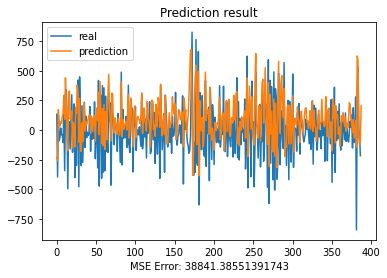

In [83]:
from sklearn.metrics.regression import mean_squared_error
y_predict = regressor.predict([x_test_price, x_test_0, x_test_1])
y_real = scaler.inverse_transform(y_test_price.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real[:-1], y_predict[:-1])))
plt.legend()
plt.title('Prediction result')
plt.show()

In [84]:
regressor.save("/content/drive/MyDrive/news-stock-rate-5-headlines.h5")

In [57]:
from keras.models import load_model
regressor = load_model("/content/drive/MyDrive/news-stock-rate-5-headlines.h5")
y_predict = regressor.predict([x_test_price, x_test_0, x_test_1])
y_real = scaler.inverse_transform(y_test_price.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()

In [58]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_real[:-1], y_predict[:-1]))
from sklearn.metrics import r2_score
print(r2_score(y_real, y_predict))

355.0847858319524
-4.716313122974926


In [59]:

headlines = []
for row in range(0, len(data.index)):
    headlines.append(' '.join(str(x) for x in data.iloc[row, 0:1]))

In [60]:
# implememt BAG OF WORDS
tfidfVector = TfidfVectorizer(ngram_range=(2,2))
#ngram(2,2) means it will combine the 2 words together and assign the value

trainDataset = tfidfVector.fit_transform(headlines)

In [61]:
randomClassifier = RandomForestClassifier(n_estimators=200, criterion='entropy')
randomClassifier.fit(trainDataset, train['Label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [62]:
testTransform =[]
for row in range(0, len(df.index)):
    testTransform.append(' '.join(str(x)[1:] for x in df.iloc[row, 2:3]))
    
test_dataset = tfidfVector.transform(testTransform)

In [63]:
pred_0 = []
pred_1 = []
predictions = randomClassifier.predict_proba(test_dataset)
print(len(predictions))
for i in predictions:
  pred_0.append(i[0])
  pred_1.append(i[1])

1989


In [64]:
print(len(pred_0))
print(len(pred_1))

1989
1989


In [65]:
from sklearn.preprocessing import MinMaxScaler
input_length = 50
output_length = 1
test_percentage = 0.2
# dataset = dj['Close'].to_numpy()

# scaler = MinMaxScaler()
# dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list_0 = []
dataset_list_1 = []
for i in range(len(pred_0) - input_length - output_length):
    dataset_list_0.append(pred_0[i:i + input_length + output_length])
    dataset_list_1.append(pred_1[i:i + input_length + output_length])
dataset_list_0 = np.array(dataset_list_0)
dataset_list_1 = np.array(dataset_list_1)
trainset_0 = dataset_list_0[:int(len(dataset_list_0) * (1 - test_percentage))]
testset_0 = dataset_list_0[int(len(dataset_list_0) * (1 - test_percentage)):]

trainset_1 = dataset_list_1[:int(len(dataset_list_1) * (1 - test_percentage))]
testset_1 = dataset_list_1[int(len(dataset_list_1) * (1 - test_percentage)):]

x_train_0 = trainset_0[:, :-1]
x_test_0 = testset_0[:, :-1]

x_train_1 = trainset_1[:, :-1]
x_test_1 = testset_1[:, :-1]

print('x_train.shape:' + str(x_train_0.shape))
print('x_test.shape:' + str(x_test_0.shape))

x_train.shape:(1550, 50)
x_test.shape:(388, 50)


In [92]:
input_tensor_c = Input(shape=( x_train_price.shape[1],1), dtype='float32')
x_c = Bidirectional(LSTM(128, return_sequences=True))(input_tensor_c)
x_c = Dropout(0.2)(x_c)
x_c = Bidirectional(LSTM(64, return_sequences=True))(x_c)
x_c = Dropout(0.2)(x_c)
x_c = Bidirectional(LSTM(32, return_sequences=False))(x_c)
x_c = Dropout(0.2)(x_c)

input_tensor_n_0 = Input(shape=( x_train_0.shape[1],1), dtype='float32')
x_n_0 = Bidirectional(LSTM(64, return_sequences=True))(input_tensor_n_0)
x_n_0 = Dropout(0.2)(x_n_0)
x_n_0 = Bidirectional(LSTM(32, return_sequences=False))(x_n_0)
x_n_0 = Dropout(0.2)(x_n_0)


input_tensor_n_1 = Input(shape=( x_train_1.shape[1],1), dtype='float32')
x_n_1 = Bidirectional(LSTM(64, return_sequences=True))(input_tensor_n_1)
x_n_1 = Dropout(0.2)(x_n_1)
x_n_1 = Bidirectional(LSTM(32, return_sequences=False))(x_n_1)
x_n_1 = Dropout(0.2)(x_n_1)

combined = Concatenate()([x_c, x_n_0, x_n_1])

mix2= Dense(256)(combined)
mix2 = Dense(128)(mix2)
mix2 = Dense(64)(mix2)
mix2 = Dense(32)(mix2)
mix2 = Dense(16)(mix2)
mix2 = Dense(8)(mix2)
mix2 = Dense(4)(mix2)

out1 = Dense(1)(mix2)


regressor = Model(inputs=[input_tensor_c,input_tensor_n_0,input_tensor_n_1],outputs=[out1])

In [93]:
regressor.compile(optimizer = "rmsprop", loss = 'mean_squared_error')
regressor.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional_35 (Bidirectional (None, 50, 256)      133120      input_16[0][0]                   
__________________________________________________________________________________________________
dropout_35 (Dropout)            (None, 50, 256)      0           bidirectional_35[0][0]           
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 50, 1)]      0                                            
____________________________________________________________________________________________

In [94]:
regressor.fit([x_train_price, x_train_0, x_train_1], [y_train_price], epochs = 100, batch_size = 8)
# regressor.save("/content/drive/MyDrive/news-stock-no-headlines.h5")

Epoch 1/100
194/194 [==============================] - 27s 52ms/step - loss: 0.3573
Epoch 2/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0094
Epoch 3/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0068
Epoch 4/100
194/194 [==============================] - 10s 52ms/step - loss: 0.0075
Epoch 5/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0075
Epoch 6/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0074
Epoch 7/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0075
Epoch 8/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0070
Epoch 9/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0056
Epoch 10/100
194/194 [==============================] - 10s 51ms/step - loss: 0.0051
Epoch 11/100
194/194 [==============================] - 10s 52ms/step - loss: 0.0049
Epoch 12/100
194/194 [==============================] - 10s 51ms/step - lo

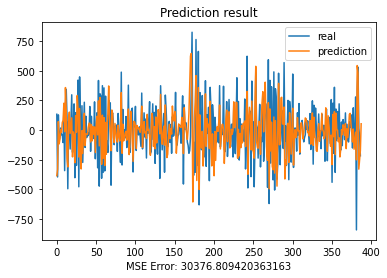

In [95]:
from sklearn.metrics.regression import mean_squared_error
y_predict = regressor.predict([x_test_price, x_test_0, x_test_1])
y_real = scaler.inverse_transform(y_test_price.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real[:-1], y_predict[:-1])))
plt.legend()
plt.title('Prediction result')
plt.show()

In [96]:
regressor.save("/content/drive/MyDrive/news-stock-rate-1-headlines.h5")

In [66]:
from keras.models import load_model
regressor = load_model("/content/drive/MyDrive/news-stock-rate-1-headlines.h5")
y_predict = regressor.predict([x_test_price, x_test_0, x_test_1])
y_real = scaler.inverse_transform(y_test_price.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()

In [67]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_real[:-1], y_predict[:-1]))
from sklearn.metrics import r2_score
print(r2_score(y_real, y_predict))

553.3174028440629
-11.196014189639708
